In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
import pandas
import pyrosetta 
import rosetta 
from sys import argv
import os 
os.environ[ "SLURM_ARRAY_TASK_ID" ] = "96" # for testing! 

In [3]:
with open( '../../mutant_list.txt' ) as fn:
    mutant_list = fn.read().split()
    mutant_name = mutant_list[ int( os.environ[ 'SLURM_ARRAY_TASK_ID' ] ) - 1 ] 

In [4]:
fmt = dict( zip( 'ANDRCQEGHILKMPFSTWYV', [ 'ALA','ASN','ASP','ARG','CYS','GLN','GLU', 'GLY','HIS','ILE','LEU','LYS','MET','PRO','PHE','SER', 'THR','TRP','TYR','VAL' ] ) ) 

In [5]:
pyrosetta.init('-extra_res_fa input_files/pNPG.params -run:preserve_header T')

Found rosetta database at: /usr/local/bin/anaconda3/lib/python3.5/site-packages/pyrosetta-4.0-py3.5.egg/database; using it....
PyRosetta-4 2016 [Rosetta 2016 unknown:7862c3a14bb5e8d6b2a4c3e0a497795bc06e9e4b 2016-12-13 14:39:52 -0500] retrieved from: git@github.com:RosettaCommons/main.git
(C) Copyright Rosetta Commons Member Institutions.
Created in JHU by Sergey Lyskov and PyRosetta Team.



In [6]:
# flags from command line 
#with open( 'input_files/flags' ) as fn:
#    flags = fn.read().replace( '\n', ' ' )
#pyrosetta.init( ''.join( flags ) ) 

In [1]:
print( x ) 

NameError: name 'x' is not defined

In [7]:
# def create_mutant_pose( mutant_name ):
#     '''
#     input: mutant name of the form H178A
#     output: pose object
#     '''
target = int( mutant_name[ 1:-1 ] )
new_res = fmt[ mutant_name[ -1 ] ] 

scorefxn = pyrosetta.create_score_function( 'beta_cst' ) 

add_cst = rosetta.protocols.enzdes.AddOrRemoveMatchCsts()
add_cst.cstfile( 'input_files/pNPG.enzdes.cst' ) 
add_cst.set_cst_action( rosetta.protocols.enzdes.CstAction.ADD_NEW )
add_cst.apply( p ) 

NameError: name 'p' is not defined

### Sampling 

Here, we place in designed rotamer, then repack and minimize the structure in a Monte Carlo simulation

In [61]:
# mutate
mut = rosetta.protocols.simple_moves.MutateResidue( target, new_res )
mut.apply( p )  

# set up pack task 
tf = rosetta.core.pack.task.TaskFactory()
around = rosetta.protocols.toolbox.task_operations.DesignAroundOperation()
around.include_residue( 446 ) #ligand 
around.include_residue( target ) 
around.repack_shell( 12 ) # let's grid search this  
around.design_shell( 12 ) 
around.resnums_allow_design( False )
around.allow_design( False )
tf.push_back( around ) 
pt = tf.create_task_and_apply_taskoperations(p)
#print( pt )

# repack and minimize 
repack = rosetta.protocols.enzdes.EnzRepackMinimize()
repack.set_scorefxn_repack( scorefxn )
repack.set_scorefxn_minimize( scorefxn )
#repack.set_min_bb( True )
#repack.set_min_lig( True )  
#repack.set_min_rb( True ) 
#repack.set_min_sc( True )
repack.task_factory( tf ) # adds packer task 
pt2 = repack.create_ptask(p)
#print( pt2 ) 

# monte carlo 
parsed = rosetta.protocols.simple_moves.GenericMonteCarloMover()
parsed.set_mover( repack )
parsed.set_maxtrials( 3 )
parsed.set_scorefxn( scorefxn )
parsed.apply( p ) 

# output PDB, probably for local testing only 
#p.dump_pdb( '/Users/alex/Desktop/output_files/{}.pdb'.format( mutant_name) ) 

### Scoring 

Here, we score the structure to obtain features 

In [63]:
scorefxn(p)

-124.22167413882343

In [64]:
pose_energies = []
for i in range( 1, 299 ): # empirically known number of score types omg 
    score_type = rosetta.core.scoring.ScoreType(i)
    score_type_str = str( score_type ).split( '.' )[ 1 ]
    score_value = rosetta.core.scoring.ScoreFunction.score_by_scoretype( scorefxn, p, score_type )
    if score_value != 0.0:
        pose_energies.append( ( score_type_str, score_value ) )
pose_energies

[('fa_atr', -2896.0625963916814),
 ('fa_rep', 434.7919932054571),
 ('fa_sol', 2080.342364508017),
 ('fa_intra_atr_xover4', -171.2307323271234),
 ('fa_intra_rep_xover4', 94.56310127195896),
 ('fa_intra_sol_xover4', 118.28659697236837),
 ('lk_ball', 1000.2156320561094),
 ('lk_ball_iso', -1134.2858917398094),
 ('lk_ball_bridge', -25.54807164457143),
 ('lk_ball_bridge_uncpl', -99.26038206556692),
 ('fa_elec', -363.32447593646094),
 ('fa_intra_elec', -7.972845961033839),
 ('pro_close', 101.56244146296436),
 ('hbond_sr_bb', -186.09142712133024),
 ('hbond_lr_bb', -98.91749936006585),
 ('hbond_bb_sc', -67.12818651328926),
 ('hbond_sc', -90.3599989542386),
 ('dslf_fa13', -1.1307896279368408),
 ('atom_pair_constraint', 47.677748467661395),
 ('angle_constraint', 0.022111500431142222),
 ('omega', 42.072299620689364),
 ('fa_dun_dev', 58.40527201907945),
 ('fa_dun_rot', 186.59775553592468),
 ('fa_dun_semi', 465.89754369753933),
 ('p_aa_pp', -79.85360206843445),
 ('hxl_tors', 84.29797630557118),
 ('r

In [65]:
res_energies = []
energies = p.energies()
for i in range( 1, p.total_residue()+1 ):
    res_name = p.residue(i).name1()
    for j in range( 300 ):
        residue_energies = p.energies().residue_total_energies( i )
        score_type = rosetta.core.scoring.ScoreType( j )
        score_type_str = str( score_type ).split( '.' )[ 1 ]
        score_value = residue_energies[ score_type ] 
        if score_value != 0.0:
            package = ( i, res_name, score_type_str, score_value )
            if len( package ) == 4:
                res_energies.append( package )
            else:
                pose_energies.append( package ) 

Mangle `res_energies` into a Pandas dataframe 

In [66]:
energy_df = pandas.DataFrame( res_energies, columns=['seqpos', 'res', 'score_term', 'score'] )
energy_df.set_index( 'seqpos', inplace=True )
energy_df.sample( 10 ) 

,res,score_term,score
seqpos,,,
52,V,fa_dun_rot,0.066967
132,W,fa_sol,2.872855
136,E,omega,-0.179074
154,E,fa_dun,3.323827
303,T,fa_intra_rep_xover4,0.103536
384,H,lk_ball_iso,9.798049
385,R,fa_elec,-1.101307
90,I,lk_ball_bridge,0.011545
71,G,fa_sol,3.019548


And pose energy would be then 

In [67]:
energy_df.groupby( 'score_term' ).apply( lambda x: x[['score']].sum() )

,score
score_term,
angle_constraint,0.022112
atom_pair_constraint,47.677748
dslf_fa13,-0.904632
fa_atr,-2896.062596
fa_dun,927.473228
fa_dun_dev,84.645322
fa_dun_rot,245.523363
fa_dun_semi,597.304543
fa_elec,-363.324476


### Active site energy calculation 

First, determine which residues are "active site residues", then score them 

In [68]:
sphere_size = 10.
active_site_residue_ids = [ p.total_residue() ]

In [69]:
lig = p.residue( p.total_residue() )
xyz = lig.atom( lig.nbr_atom() ).xyz() 
for i in range( 1, p.total_residue() ):
    res = p.residue( i ) 
    res_xyz = res.atom( res.nbr_atom() ).xyz()
    if xyz.distance( res_xyz ) < sphere_size:
        active_site_residue_ids.append( i ) 

In [70]:
active_site_residue_ids

[446,
 14,
 16,
 19,
 119,
 120,
 163,
 164,
 166,
 167,
 171,
 178,
 218,
 220,
 293,
 295,
 353,
 399,
 406,
 407,
 415]

In [71]:
len(active_site_residue_ids)

21

In [72]:
active_site_energies = energy_df.loc[ active_site_residue_ids ] 
print( len( active_site_energies ) ) 
active_site_energy = active_site_energies.groupby( 'score_term' ).apply( lambda x: x[['score']].sum() ) 
active_site_energy.index = [ '{}_active_site'.format(i) for i in active_site_energy.index ] 
active_site_energy

456


,score
angle_constraint_active_site,0.022112
atom_pair_constraint_active_site,47.677748
fa_atr_active_site,-194.202446
fa_dun_active_site,61.581454
fa_dun_dev_active_site,5.194684
fa_dun_rot_active_site,1.986248
fa_dun_semi_active_site,54.400522
fa_elec_active_site,-24.985371
fa_elec_bb_bb_active_site,-3.063314
fa_elec_bb_sc_active_site,1.405440


In [73]:
constrained_res = []
cst_set = p.constraint_set()
for i in cst_set.get_all_constraints():
    for j in i.residues():
        constrained_res.append(j)
constrained_res = set(constrained_res)
constrained_res

{164, 295, 353, 446}

In [74]:
dfs = []
for i, res in enumerate( constrained_res ):
    dat = energy_df.loc[ res ].copy()
    dat['expanded_score_term'] = [ 'SR_{}_{}'.format(i+1, term) for term in dat.score_term ]
    dfs.append( dat ) 
    
enzyme_design_scorefile = pandas.concat( dfs ) 
enzyme_design_scorefile[['expanded_score_term', 'score']]

,expanded_score_term,score
seqpos,,
353,SR_1_fa_atr,-8.676672
353,SR_1_fa_rep,6.972687
353,SR_1_fa_sol,9.530680
353,SR_1_fa_intra_atr_xover4,-0.350806
353,SR_1_fa_intra_rep_xover4,0.254401
353,SR_1_fa_intra_sol_xover4,0.476116
353,SR_1_lk_ball,3.538147
353,SR_1_lk_ball_iso,10.072555
353,SR_1_lk_ball_bridge,0.461786


In [75]:
plt.style.use( 'bmh' ) 

In [76]:
my_df = enzyme_design_scorefile[['expanded_score_term', 'score']]
my_df.index = range( len( my_df ) ) 

/usr/local/bin/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


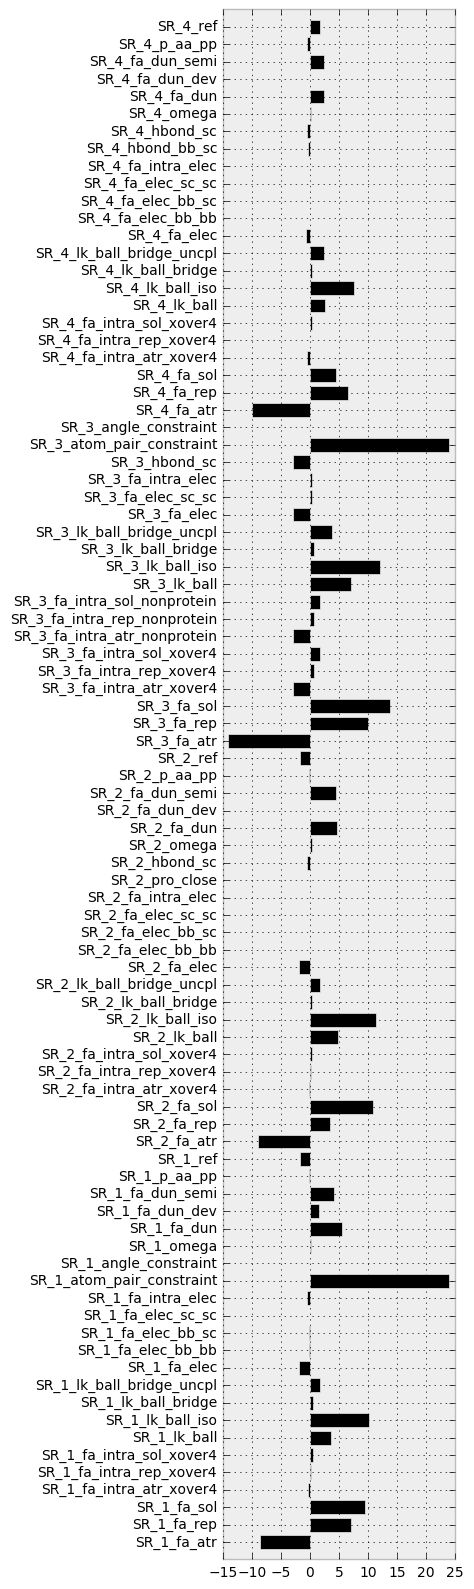

In [77]:
fig, ax = plt.subplots( 1, 1, figsize=(3, 20) ) 
ax.barh( my_df.index, my_df.score, align='center', color='k' )
ax.set_yticks( my_df.index ) 
ax.set_yticklabels( my_df.expanded_score_term ) 
ax.set_ylim( -1, len( my_df ) ) 
fig.show()

### Defining constraints in a way that a chemist would love 

Define constraints such as "either carbonyl oxygen of Glu 353 to within 2 Ångstroms of the anomeric carbon of the substrate pNPG", and [angle example], and [dihedral example].

In [78]:
def resolve_atom( p, atm, pos ): # atom id, type, or name; residue position     
    if isinstance( atm, int ):
        return rosetta.core.id.AtomID( atm, pos )
    elif isinstance( atm, str ):
        res_ = p.residue( pos ) 
        for i in range( 1, res_.natoms()+1 ):
            atom_name = res.atom_name(i)
            if atm == atom_name:
                return rosetta.core.id.AtomID( i, pos )
            atoms_that_match = []
            atom_type = res.atom_type(i)
            if atm == atom_type.name():
                atoms_that_match.append( i ) 

def make_chemical_constraint( pose, res1_atom, res1_pos, res2_atom, res2_pos, x, sd ):    
    atoms = ( resolve_atom(pose, res1_atom, res1_pos), resolve_atom(pose, res2_atom, res2_pos) )
    func = rosetta.core.scoring.func.HarmonicFunc( x, sd )
    cst = rosetta.core.scoring.constraints.AtomPairConstraint( *atoms, func ) 
    return cst

In [79]:
distance_1 = {
    'res1_atom': 9,
    'res1_pos': 353,
    'res2_atom': 1, 
    'res2_pos': 446, 
    'x': 2.0, 
    'sd': .2, 
}

cst_1 = make_chemical_constraint( p, **distance_1 ) 

In [80]:
p.add_constraint( cst_1 ) 
scorefxn( p ) 

-76.54392567116187

In [81]:
def get_residue_energies_from_pose( p ):
    res_energies = []
    energies = p.energies()
    for i in range( 1, p.total_residue() ):
        res_name = p.residue(i).name1()
        for j in range( 299 ):
            residue_energies = energies.residue_total_energies( i )
            score_type = rosetta.core.scoring.ScoreType( j )
            score_type_str = str( score_type ).split( '.' )[ 1 ]
            score_value = residue_energies[ score_type ] 
            if score_value != 0.0:
                package = ( i, res_name, score_type_str, score_value )
                if len( package ) == 4:
                    res_energies.append( package )
                    
    energy_df = pandas.DataFrame( res_energies, columns=['seqpos', 'res', 'score_term', 'score'] )
    #energy_df.set_index( 'seqpos', inplace=True )
    #energy_df.sample( 10 ) 
    return energy_df

Dataframe of each score term for each residue (long-form)

In [86]:
df = get_residue_energies_from_pose(p)
df.sample(12)

,seqpos,res,score_term,score
7115,350,L,lk_ball_bridge_uncpl,0.975955
1002,51,D,fa_sol,3.469243
5989,296,T,omega,-0.027634
765,38,C,lk_ball_iso,6.111172
5533,274,F,lk_ball_bridge_uncpl,1.950859
8436,415,F,fa_dun_semi,2.523872
7982,393,L,fa_dun,1.187273
7363,362,L,fa_dun,3.593137
7853,386,F,ref,1.960200
3494,171,L,fa_dun,0.443618


What we would usually think of as a "score file": a list of each energy term and its sum across every residue 

In [88]:
df.groupby( 'score_term' ).apply( lambda x: x[['score']].sum() ) 

,score
score_term,
angle_constraint,0.011056
atom_pair_constraint,47.677748
dslf_fa13,-0.904632
fa_atr,-2881.888113
fa_dun,927.473228
fa_dun_dev,84.645322
fa_dun_rot,245.523363
fa_dun_semi,597.304543
fa_elec,-360.335543
